# Lab 5: Daisyworld

<div id="prob_initial"></div>


### Problem Initial
The feedback means a stable daisy population (a
steady state) and the environmental conditions are in a delicate
balance. The code below produces a steady state which arises from a given initial daisy
population,

1.  Add a small initial fraction of black daisies (say, 0.01) to the
    value in initial.yaml and see
    what effect this has on the temperature and final daisy populations.
    Do you still have a final non-zero daisy population?

        The effect of changing the initial population of black daisies by 0.01 has an effect of 0.001 in the final population of black daisies and 0.0001 in the white daisies population. This will result in very slight increase of temperature.


2.  Attempt to adjust the initial white daisy population to obtain a
    non-zero steady state. Do you have to increase or decrease the
    initial fraction? What is your explanation for this behavior?

        I could not obtain a non zero steady state for black daisies. No matter how much I increase or reduce the initial conditions of white daisies.

3.  Experiment with other initial fractions of daisies and look for
    non-zero steady states.

        The reason why there's no steady state for black daisies is because L is too large and the local temperature of white daisies is too high. In initial4.yaml I changed L from 1.3 to 1 and now we see a non zero steady state for black daisies.

    

In [141]:
# functions for problem initial
import context
from collections import namedtuple
import numpy as np
from numlabs.lab5.lab5_funs_jose import Integrator


class Integ54(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi)
        f[1] = y[1] * (beta_b * bare - user.chi)
        return f

Final equilibrium temperature: 29.0698, population of black daisies: 0.0123 and white ones: 0.6447
Final equilibrium temperature: 29.2614, population of black daisies: 0.0133 and white ones: 0.6445


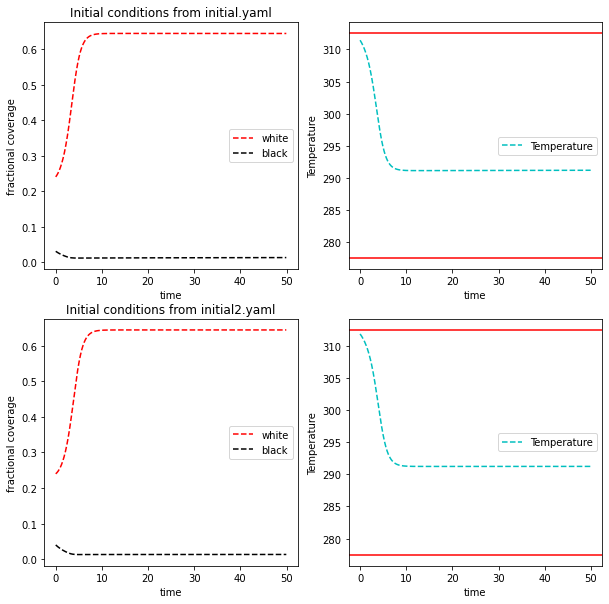

In [142]:
# Solve and plot for problem initial
import matplotlib.pyplot as plt
import pandas as pd

def plott(initial1,initial2):
    theSolver = Integ54(initial1)
    timevals, yvals, errorlist,temp_w, temp_b, temp_e  = theSolver.timeloop5fixed()
    daisies = pd.DataFrame(yvals, columns=['white', 'black'])

    thefig, theAx = plt.subplots(2, 2,figsize=(10,10))
    line1, = theAx[0,0].plot(timevals, daisies['white'])
    line2, = theAx[0,0].plot(timevals, daisies['black'])
    
    line3, = theAx[0,1].plot(timevals, temp_e)
    #line4, = theAx[0,1].plot(timevals, temp_b)
    theAx[0,1].axhline(y=312.5, color='r', linestyle='-')
    theAx[0,1].axhline(y=277.5, color='r', linestyle='-')
    theAx[0,1].set_ylabel('Temperature')
    theAx[0,1].set_xlabel('time')
    line3.set(linestyle='--', color='c', label='Temperature')
    #line4.set(linestyle='-', color='b', label='black T')
    line1.set(linestyle='--', color='r', label='white')
    line2.set(linestyle='--', color='k', label='black')
    theAx[0,0].set_title('Initial conditions from '+initial1)
    theAx[0,0].set_xlabel('time')
    theAx[0,0].set_ylabel('fractional coverage')
    out = theAx[0,0].legend(loc='center right')
    theAx[0,1].legend(loc='center right')
    bd=daisies['black'].iloc[-1]
    wd=daisies['white'].iloc[-1]
    print(f'Final equilibrium temperature: {round(np.mean(temp_b)-273.15,4)}, population of black daisies: {round(bd,4)} and white ones: {round(wd,4)}')

    theSolver = Integ54(initial2)
    timevals, yvals, errorlist,temp_w, temp_b, temp_e  = theSolver.timeloop5fixed()
    daisies = pd.DataFrame(yvals, columns=['white', 'black'])
    line3, = theAx[1,1].plot(timevals, temp_e)
    #line4, = theAx[1,1].plot(timevals, temp_e)
    line3.set(linestyle='--', color='c', label='Temperature')
    #line4.set(linestyle='-', color='b', label='black T')
    theAx[1,1].set_ylabel('Temperature')
    theAx[1,1].set_xlabel('time')
    theAx[1,1].axhline(y=312.5, color='r', linestyle='-')
    theAx[1,1].legend(loc='center right')
    theAx[1,1].axhline(y=277.5, color='r', linestyle='-')
    line1, = theAx[1,0].plot(timevals, daisies['white'])
    line2, = theAx[1,0].plot(timevals, daisies['black'])
    line1.set(linestyle='--', color='r', label='white')
    line2.set(linestyle='--', color='k', label='black')
    theAx[1,0].set_title('Initial conditions from '+initial2)
    theAx[1,0].set_xlabel('time')
    theAx[1,0].set_ylabel('fractional coverage')
    out = theAx[1,0].legend(loc='center right')
    bd=daisies['black'].iloc[-1]
    wd=daisies['white'].iloc[-1]
    print(f'Final equilibrium temperature: {round(np.mean(temp_b)-273.15,4)}, population of black daisies: {round(bd,4)} and white ones: {round(wd,4)}')

plott('initial.yaml','initial2.yaml')

Final equilibrium temperature: 30.1187, population of black daisies: 0.021 and white ones: 0.6432
Final equilibrium temperature: 23.4064, population of black daisies: 0.2676 and white ones: 0.4088


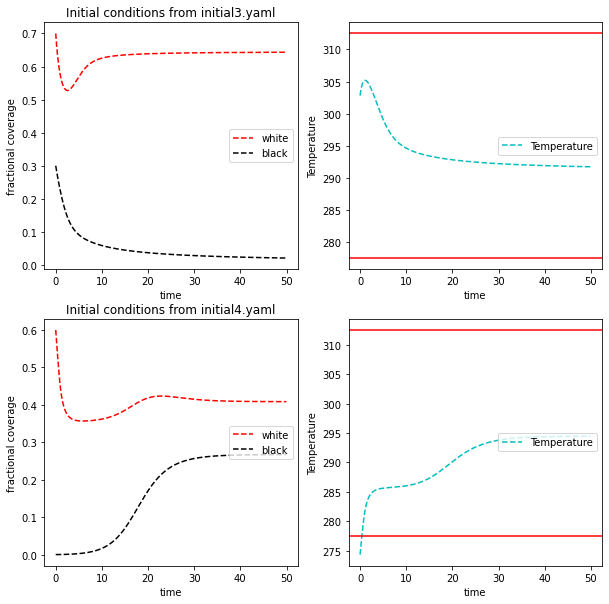

In [143]:
plott('initial3.yaml','initial4.yaml')

### Problem Estimate
In the demo below, compare the error estimate to the true error, on the initial value problem from Lab 4,

$$\frac{dy}{dt} = -y +t +1,  \;\;\;\; y(0) =1$$

which has the exact solution

$$y(t) = t + e^{-t}$$

1.  Play with the time step and final time, attempting small changes at first. How reasonable is the error estimate?

        It looks like for this example with growing error in time, the effect of doubling the timestep is less important than the effect of doubling the final time.

2.  Keep decreasing the time step. Does the error estimate diverge from the computed error? Why?

        The smaller the time step the less the two error differ. The accumulated error becomes less important the smaller the timestep is.

3.  Keep increasing the time step. Does the error estimate diverge? What is happening with the numerical solution?

        The first increase made the error bigger but it seemed like the difference between the two error was smaller. However, for dt=4 the numerical solution fails and both errors become huge, with enormous differences (note the order of magnitude of the error).

In [144]:
# Functions for problem estimate
from numlabs.lab5.lab5_funs import Integrator


class Integ55(Integrator):
    def set_yinit(self):
        #
        # read in 'c1 c2 c3'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in initial yinit
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array([self.initvars.yinit])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def derivs5(self, y, theTime):
        """
           y[0]=fraction white daisies
        """
        user = self.uservars
        f = np.empty_like(self.yinit)
        f[0] = user.c1 * y[0] + user.c2 * theTime + user.c3
        return f

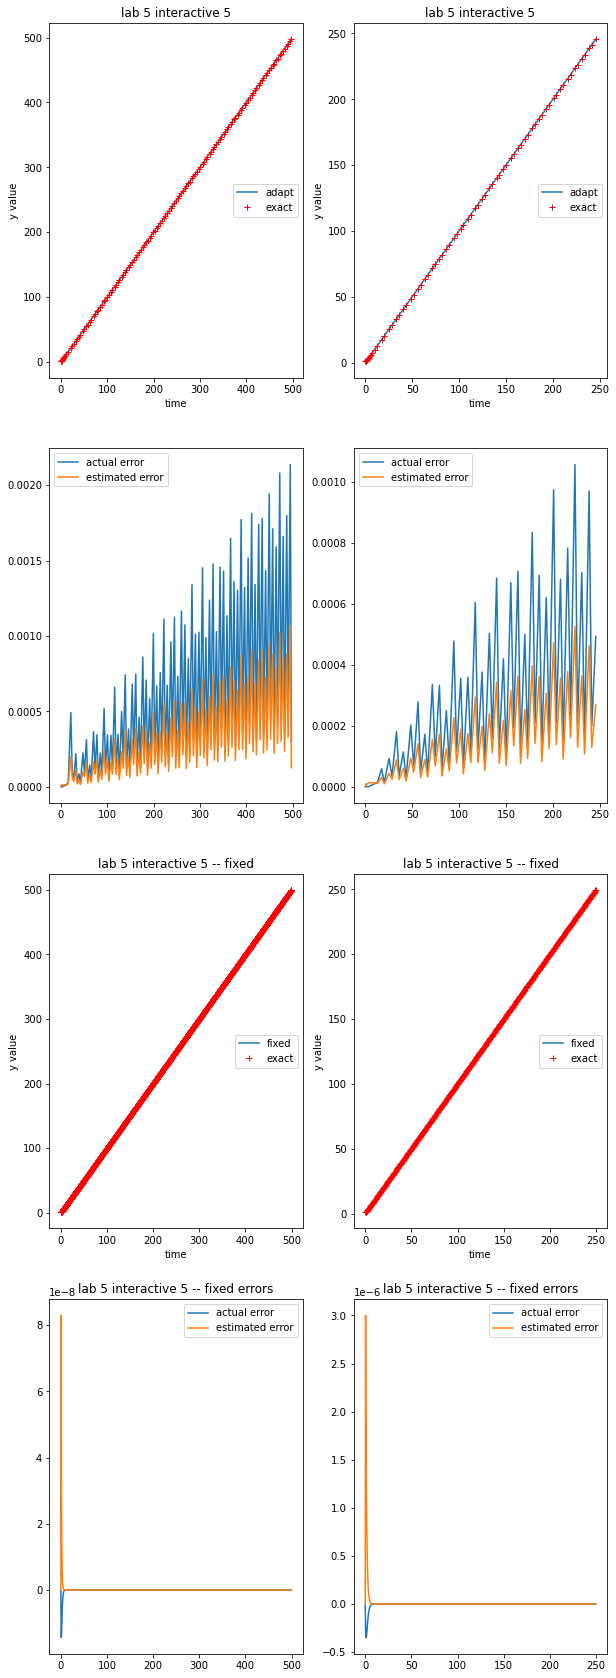

In [145]:
# Solve and plot for problem estimate

def plott1(theAx,c,expon0):
    theSolver = Integ55(expon0)

    timeVals, yVals, yErrors = theSolver.timeloop5Err()
    timeVals = np.array(timeVals)
    exact = timeVals + np.exp(-timeVals)
    yVals = np.array(yVals)
    yVals = yVals.squeeze()
    yErrors = np.array(yErrors)

    line1 = theAx[0,c].plot(timeVals, yVals, label='adapt')
    line2 = theAx[0,c].plot(timeVals, exact, 'r+', label='exact')
    theAx[0,c].set_title('lab 5 interactive 5')
    theAx[0,c].set_xlabel('time')
    theAx[0,c].set_ylabel('y value')
    theAx[0,c].legend(loc='center right')

    #
    # we need to unpack yvals (a list of arrays of length 1
    # into an array of numbers using a list comprehension
    #

    realestError = yVals - exact
    actualErrorLine = theAx[1,c].plot(timeVals, realestError, label='actual error')
    estimatedErrorLine = theAx[1,c].plot(timeVals, yErrors, label='estimated error')
    theAx[1,c].legend(loc='best')

    timeVals, yVals, yErrors = theSolver.timeloop5fixed()

    np_yVals = np.array(yVals).squeeze()
    yErrors = np.array(yErrors)
    np_exact = timeVals + np.exp(-timeVals)

    line1 = theAx[2,c].plot(timeVals, np_yVals, label='fixed')
    line2 = theAx[2,c].plot(timeVals, np_exact, 'r+', label='exact')
    theAx[2,c].set_title('lab 5 interactive 5 -- fixed')
    theAx[2,c].set_xlabel('time')
    theAx[2,c].set_ylabel('y value')
    theAx[2,c].legend(loc='center right')

    realestError = np_yVals - np_exact
    actualErrorLine = theAx[3,c].plot(timeVals, realestError, label='actual error')
    estimatedErrorLine = theAx[3,c].plot(timeVals, yErrors, label='estimated error')
    theAx[3,c].legend(loc='best')
    theAx[3,c].set_title('lab 5 interactive 5 -- fixed errors')
    
def plott(expon0,expon1):
    fig, axs = plt.subplots(4,2,figsize=(10,30))
    plott1(axs,0,expon0)
    plott1(axs,1,expon1)
    
expon0='expon.yaml'
expon1='expon2.yaml'
plott(expon0,expon1)                            

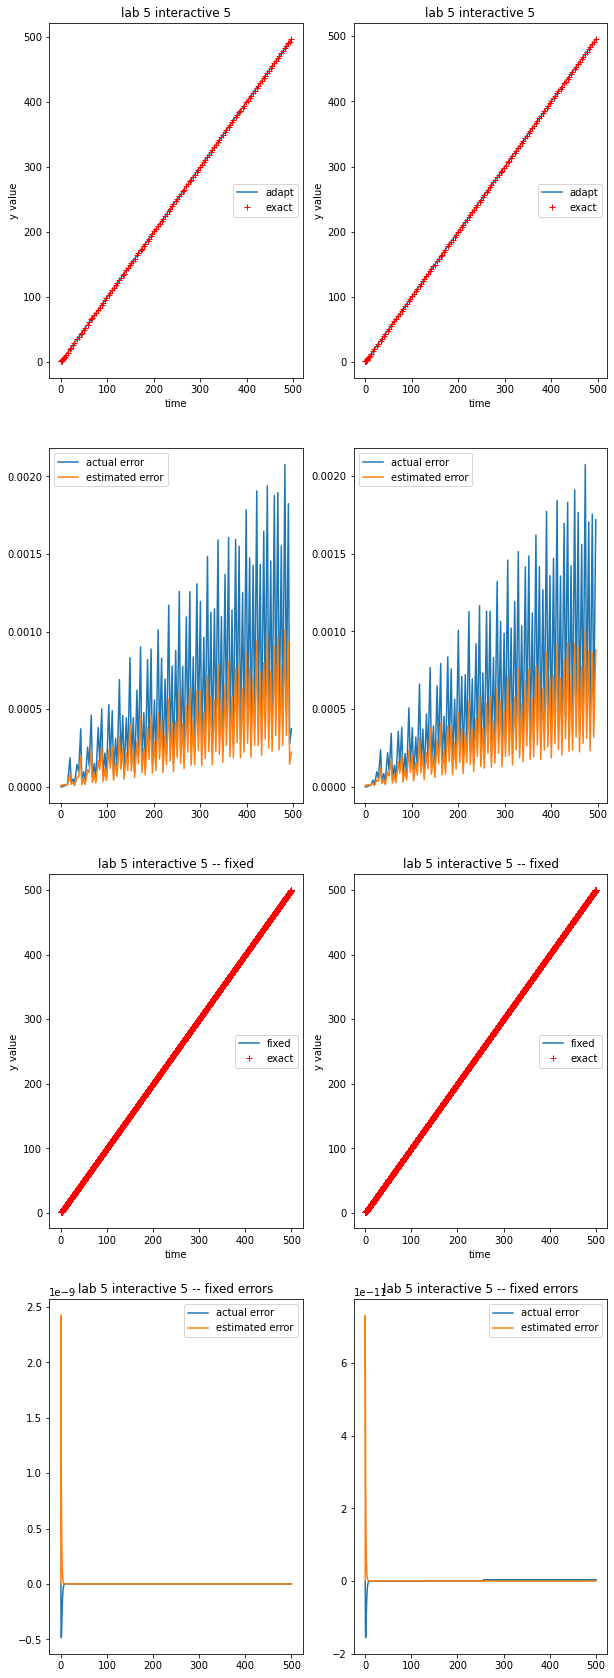

In [146]:
expon0='expon3.yaml'
expon1='expon4.yaml'
plott(expon0,expon1) 

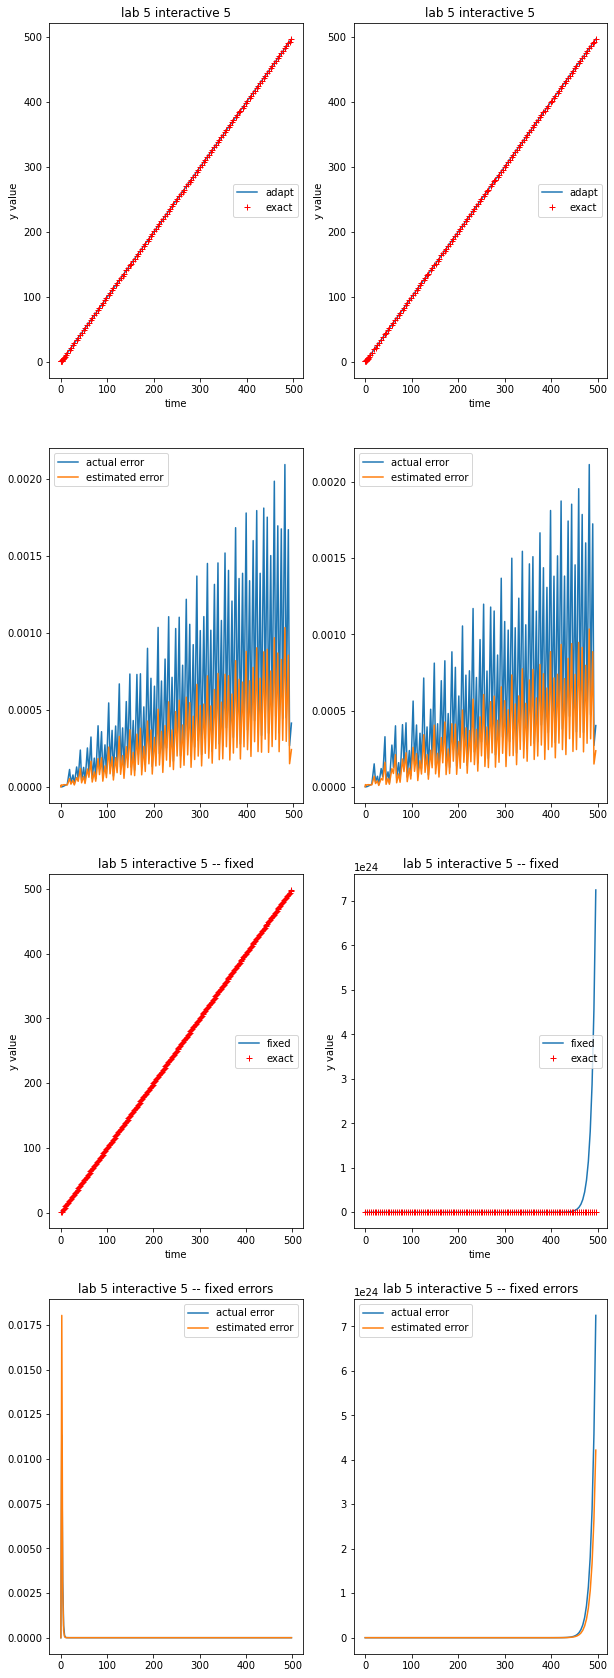

In [147]:
expon0='expon5.yaml'
expon1='expon6.yaml'
plott(expon0,expon1) 

### Problem adaptive
The demos in the previous section solved the Daisyworld equations using the embedded Runge-Kutta methods with adaptive timestep control.

1.  Run the code and find solutions of Daisyworld with the default settings found in adapt.yaml using the timeloop5Err adaptive code

2.  Find the solutions again but this time with fixed stepsizes and compare the size of the timesteps and number of the timesteps.

        The average timestep size is about 20 times as large for the adaptive method (0.1 vs 1.86) and the number of time steps is about 20 times fewer (500 vs 23). 

3.  How much faster does the fixed timeloop need to be to give the same performance as the adaptive timeloop for this case?

        Apparently, the fixed loop would need to be 21.74 times faster than the adaptative to achieve the same perfomance.


The average time step is 1.8630049510559055 and the number or timesteps is 23


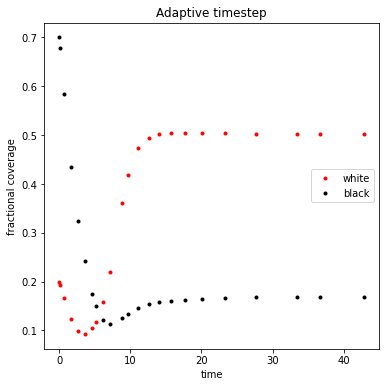

In [148]:
theSolver = Integ54('adapt.yaml')
timevals, yvals, errorlist  = theSolver.timeloop5Err()
daisies = pd.DataFrame(yvals, columns=['white', 'black'])

thefig, theAx = plt.subplots(1,1,figsize=(6,6))
theAx.plot(timevals, daisies['white'],'r.', label='white')
theAx.plot(timevals, daisies['black'],'k.', label='black')

theAx.set_title('Adaptive timestep')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')

print(f'The average time step is {timevals[-1]/len(timevals)} and the number or timesteps is {len(timevals)}')

With a fixed timestep of 0.1, the number or timesteps needed is 500


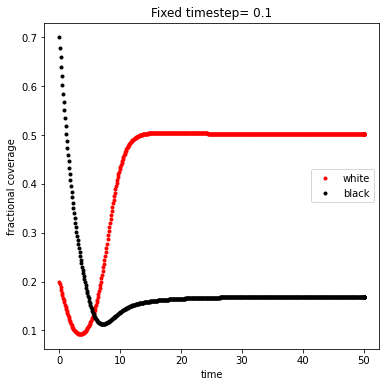

In [149]:
theSolver = Integ54('adapt2.yaml')
timevals, yvals, errorlist  = theSolver.timeloop5Err()
daisies = pd.DataFrame(yvals, columns=['white', 'black'])

thefig, theAx = plt.subplots(1,1,figsize=(6,6))
theAx.plot(timevals, daisies['white'],'r.', label='white')
theAx.plot(timevals, daisies['black'],'k.', label='black')

theAx.set_title('Fixed timestep= 0.1')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')
print('With a fixed timestep of 0.1, the number or timesteps needed is 500')

In [150]:
print(f'The fixed method with dt = 0.1 should be {round(500/23,2)} times faster to give the same performance as the adaptive method')

The fixed method with dt = 0.1 should be 21.74 times faster to give the same performance as the adaptive method


<a name="prob_predator"></a>


### Problem Predator
To make life a little more interesting on Daisyworld, add a population of rabbits that feed upon the daisies. The
rabbit birth rate will be proportional to the area covered by the daisies while, conversely, the daisy *death rate* will be proportional to the rabbit population.

Add another equation to the Daisyworld model which governs the rabbit population and make the appropriate modifications to the existing daisy equations. Modify the set of equations and solve it with the Runge-Kutta method with adaptive timesteps. Use it to look for steady states and to determine their dependence on the initial conditions and model parameters.

Hand in notebook cells that:

1.  Show your modified Daisyworld equations and your new integrator class.

2.  At least one set of parameter values and initial conditions that leads to the steady state and a plot of the timeseries for the daisies and rabbits.

3.  A discussion of the steady state’s dependence on these values, i.e. what happens when they are altered. Include a few plots for illustration.

        For this model, the rabbit population would continue to grow until daisies population  is 0 and then It will stop growing (inmortal rabbits). Thus, although initial conditions can differ the final steady state of the rabbit population, this cannot change the final steady state of daisies which will be 0.

4.  Does adding this feedback extend the range of habital L values  for which non-zero populations exist?

        If anything it reduces the range as it does not matter what value you choose, eventually all the flowers will be grazed.

**Bonus:**: Now consider foxes that prey on rabbits but
leave the daisies alone.

        I have included foxes in the set of equations, but set their population to 0 in the first examples. Their population is not growing exponentially as rabbits do, this one is simply dependent of the rabbit population and will represent a proportion of it. When adding foxes we are reducing the pressure on daisies and we do find non zero steady oscillating states instead of reaching equilibrium.

In [151]:
# Functions for problem estimate
from numlabs.lab5.lab5_funs import Integrator


class IntegPred(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc, self.initvars.Pr0,self.initvars.Fox])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def rabbit_pop(self, yvals):
        """
            Calculate the population of rabbits
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  New population of rabbits
        """
        user=self.uservars
        Area = (yvals[0] + yvals[1])
        if yvals[2]>yvals[3] and yvals[3]>0:
            if Area > 1e-5:
                Pr =  (Area)*yvals[2] - yvals[3]
                Chi = user.chi*np.log10(yvals[2])
                Fx = user.PF*Pr
            else:
                Pr = - yvals[3] 
                Chi = user.chi
                Fx = user.PF*Pr
        if yvals[2]>yvals[3] and yvals[3]==0:
            if Area > 1e-5:
                Pr =  (Area)*yvals[2] - yvals[3]
                Chi = user.chi*np.log10(yvals[2])
                Fx = 0
            else:
                Pr = - yvals[3] 
                Chi = user.chi
                Fx = 0
        if yvals[2]<yvals[3]:
            Fx = 0
            Pr = 0
            Chi = user.chi
            
        return (Chi,Pr,Fx)
    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[2]=Population of rabbits
           y[3]=Population of foxes
           
        """
        temp_w, temp_b, temp_e = self.find_temp(y)
        Chi,Pr,Fx = self.rabbit_pop(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[3]= Fx
        f[2]= Pr
        f[0] = y[0] * (beta_w * bare - Chi)
        f[1] = y[1] * (beta_b * bare - Chi)
        return f

In [152]:
import sys  #output to sys.stdout because print adds blank lines
with open('predator.yaml', 'r') as f:
    for line in f.readlines():
        sys.stdout.write(line)

timevars:
  dt: 0.1
  tstart: 0.0
  tend: 50.0
uservars:
  albedo_white: 0.75
  S0: 3668.0
  L: 1.1
  PF: 0.1
  albedo_black: 0.25
  R: 0.12
  chi: 0.3
  sigma: 5.67e-08
  albedo_ground: 0.5
initvars:
  whiteconc: 0.2
  blackconc: 0.7
  Pr0: 2
  Fox: 0
adaptvars:
  dtpassmin: 0.1
  dtfailmax: 0.5
  dtfailmin: 0.1
  s: 0.9
  rtol: 1.0e-05
  atol: 1.0e-05
  maxsteps: 2000.0
  maxfail: 60.0
  dtpassmax: 5.0


The average time step is 1.7544312867214271 and the number or timesteps is 26


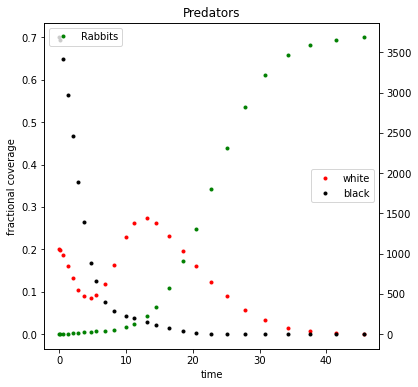

In [153]:
theSolver = IntegPred('predator.yaml')
timevals, yvals, errorlist  = theSolver.timeloop5Err()
daisies = pd.DataFrame(yvals, columns=['white', 'black','Rabbit','Fox'])

thefig, theAx = plt.subplots(1,1,figsize=(6,6))
theAx.plot(timevals, daisies['white'],'r.', label='white')
theAx.plot(timevals, daisies['black'],'k.', label='black')
Ax=theAx.twinx()
Ax.plot(timevals, daisies['Rabbit'],'g.', label='Rabbits')

theAx.set_title('Predators')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')
out = plt.legend(loc='upper left')

print(f'The average time step is {timevals[-1]/len(timevals)} and the number or timesteps is {len(timevals)}')

In [154]:
import sys  #output to sys.stdout because print adds blank lines
with open('predator2.yaml', 'r') as f:
    for line in f.readlines():
        sys.stdout.write(line)

timevars:
  dt: 0.1
  tstart: 0.0
  tend: 50.0
uservars:
  albedo_white: 0.75
  S0: 3668.0
  L: 1.1
  PF: 0.1
  albedo_black: 0.25
  R: 0.12
  chi: 0.3
  sigma: 5.67e-08
  albedo_ground: 0.5
initvars:
  whiteconc: 0.3
  blackconc: 0.3
  Pr0: 2
  Fox: 0
adaptvars:
  dtpassmin: 0.1
  dtfailmax: 0.5
  dtfailmin: 0.1
  s: 0.9
  rtol: 1.0e-05
  atol: 1.0e-05
  maxsteps: 2000.0
  maxfail: 60.0
  dtpassmax: 5.0


The average time step is 1.830317790365866 and the number or timesteps is 25


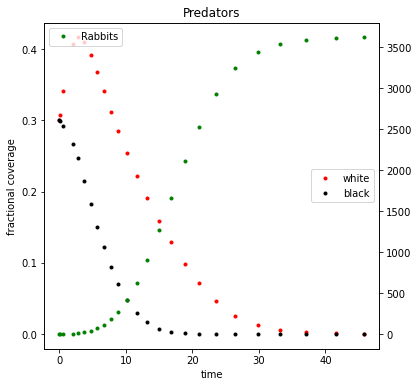

In [155]:
theSolver = IntegPred('predator2.yaml')
timevals, yvals, errorlist  = theSolver.timeloop5Err()
daisies = pd.DataFrame(yvals, columns=['white', 'black','Rabbit','Fox'])

thefig, theAx = plt.subplots(1,1,figsize=(6,6))
theAx.plot(timevals, daisies['white'],'r.', label='white')
theAx.plot(timevals, daisies['black'],'k.', label='black')
Ax=theAx.twinx()
Ax.plot(timevals, daisies['Rabbit'],'g.', label='Rabbits')

theAx.set_title('Predators')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')
out = plt.legend(loc='upper left')

print(f'The average time step is {timevals[-1]/len(timevals)} and the number or timesteps is {len(timevals)}')

The average time step is 3.0769898503045914 and the number or timesteps is 31


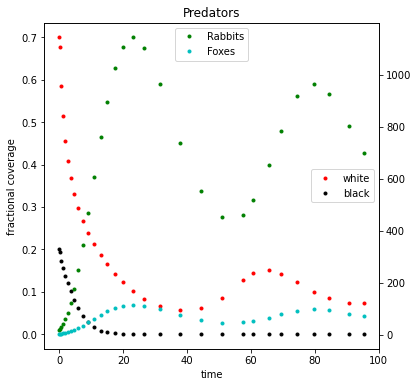

In [156]:
theSolver = IntegPred('foxes.yaml')
timevals, yvals, errorlist  = theSolver.timeloop5Err()
daisies = pd.DataFrame(yvals, columns=['white', 'black','Rabbit','Fox'])

thefig, theAx = plt.subplots(1,1,figsize=(6,6))
theAx.plot(timevals, daisies['white'],'r.', label='white')
theAx.plot(timevals, daisies['black'],'k.', label='black')
Ax=theAx.twinx()
Ax.plot(timevals, daisies['Rabbit'],'g.', label='Rabbits')
Ax.plot(timevals, daisies['Fox'],'c.', label='Foxes')

theAx.set_title('Predators')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')
Ax.legend(loc='upper center')

print(f'The average time step is {timevals[-1]/len(timevals)} and the number or timesteps is {len(timevals)}')

## Predator: Daisy World Equations

$$\frac{dA_w}{dt} = A_w ( \beta_w x - \chi)$$

$$\frac{dA_b}{dt} = A_b ( \beta_b x - \chi)$$

$$\frac{dP_r}{dt} = P_r(A_w + A_b) - P_z$$

$$P_z= \beta_F P_r$$

$$\chi = \chi_0log(P_r)$$

$$x = 1 - A_w - A_b$$

$$\beta_i = 1.0 - 0.003265(295.5 K -T_i)^2$$

$$T^4_i = R L \frac{S_0}{4\sigma}(\alpha_p-\alpha_i) + T^4_e$$

$$\alpha_p = A_w\alpha_w + A_b\alpha_b + A_g\alpha_g$$

$$T^4_e = L \frac{S_0}{4\sigma}(1-\alpha_p)$$